## Base de Dados
A base de dados conta com registros de partidas profissionais de Dota 2, contendo o número de identificador de cada personagem selecionado, a taxa de vitória desse personagem selecionado e a medalha da pessoa jogadora.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# variável usada para remover warnings do jupyter notebook
import warnings
warnings.filterwarnings('ignore')

# leitura e transformação do arquivo em dataframe
dados = pd.read_csv('dadospartidaspro.csv')
#dados = dados.drop_duplicates()

dados = dados.drop(columns=['Unnamed: 0', 'id', 'taxavitoria1', 'taxavitoria2', 'taxavitoria3', 'taxavitoria4', 'taxavitoria5',
                           'taxavitoria6', 'taxavitoria7', 'taxavitoria8', 'taxavitoria9', 'taxavitoria10'])
dados['winner'] = dados['winner'].apply(lambda item: 1 if item == 'radiant' else 0)
dados

,winner,pick1,rank1,pick2,rank2,pick3,rank3,pick4,rank4,pick5,...,pick6,rank6,pick7,rank7,pick8,rank8,pick9,rank9,pick10,rank10
0,1,103,80,137,80,40,80,53,80,86,...,52,80,106,80,32,80,51,80,89,80
1,0,48,52,11,54,128,45,110,75,85,...,30,75,100,75,45,75,105,75,53,75
2,0,54,80,120,80,69,80,123,80,58,...,18,80,65,80,96,80,86,80,91,80
3,0,136,80,74,80,108,80,10,80,86,...,43,80,100,80,46,80,75,80,53,80
4,1,85,75,25,75,128,75,129,75,70,...,6,52,22,54,137,45,110,75,5,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,1,126,70,87,70,96,70,109,70,11,...,121,70,69,70,63,70,138,70,89,70
1383,1,73,70,33,70,85,70,96,70,21,...,68,70,75,70,129,70,8,70,106,70
1384,1,104,80,126,80,75,80,5,80,70,...,111,80,106,80,136,80,91,80,73,80
1385,0,73,80,94,70,90,80,2,70,59,...,62,70,14,70,86,70,87,70,120,70


## Escolha do Melhor Algoritmo
Para a escolha do melhor algoritmo foram utilizados de diversos algoritmos explorados na literatura, de forma que foi calculado sua acurácia e sua precisão. O algoritmo com melhor precisão foi escolhido e a partir disso feito um ajuste dos parâmetros para determinar a melhor precisão possível para o problema.

Melhor Algoritmo Escolhido:
Precisão e Acurácia:
Precisão e Acurácia depois do Ajuste de Parâmetros:

### Funções Auxiliares
Para auxiliar nos cálculos necessários de verificação dos algoritmos foram desenvolvidas algumas funções que realizam o cálculo e impressão das métricas, separação do conjunto de teste, entre outras questões, como por exemplo salvar os dados no framework MLFlow, que facilitou a leitura a verificação dos melhores resultados.

In [2]:
import mlflow
import mlflow.sklearn
import os

# função auxiliar para criar um experimento no mlflow
def criarExperimento():
    # variáveis de conexão com o mlflow
    os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/stardotwav/Dota2Predictor.mlflow"
    os.environ['MLFLOW_TRACKING_USERNAME'] = "stardotwav"
    os.environ['MLFLOW_TRACKING_PASSWORD'] = "7dcb76dec399290fb3a125d02a9a7b39e2c03d90"
    
    mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])
    mlflow.set_experiment(experiment_name='Personagens Selecionados e Medalha das Pessoas Jogadoras')

    tags = {
            "Projeto": "Projeto de Engenharia de Aprendizado de Máquina",
            "team": "Estela",
            "dataset": "dota2teamsprofessionals"
           }

In [3]:
# função auxiliar que salva os dados no MLFlow
def modelosMLFlow(acuracia, precisao, modelo, nomeModelo):
    with  mlflow.start_run(run_name=nomeModelo):
        # registro das métricas
        mlflow.log_metric("Acurácia", acuracia)
        mlflow.log_metric("Precisão", precisao)
        
        # registro do modelo
        mlflow.sklearn.log_model(modelo, "Modelo")
        mlflow.end_run()

In [4]:
# import utilizado para realizar a separação do treino e teste
from sklearn.model_selection import train_test_split

# função auxiliar que realiza a separação do dataset em treino e teste
def separacaoModelo(dataset, target):
    X = dataset.drop(target, axis=1)
    Y = dataset[target]
    xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    return xTrain, xTest, yTrain, yTest

In [5]:
# import de algoritmos utilizados
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# função auxiliar que gerar qualquer modelo de acordo com seu nome
def gerarModelo(xTrain, xTest, yTrain, yTest, modelo):
    md = modelo
    md.fit(xTrain, yTrain)
    pred = md.predict(xTest)
    
    return md, pred

In [6]:
# import do cross_validation
from sklearn.model_selection import cross_val_score

# grafico que gera comparação entre diversos algoritmos
def graficoComparacao(algoritmos, x, y):
    scores = {}
    for i in algoritmos:
        scores[type(i).__name__] = cross_val_score(i, x, y, cv=30, scoring='precision')

    scores = pd.DataFrame.from_dict(scores)
    plt.figure(figsize = (15,10))
    sns.boxplot(data = scores, palette='rocket')

In [7]:
# gerando base de dados
xTrain, xTest, yTrain, yTest = separacaoModelo(dados, 'winner')

In [8]:
# criando experimento
criarExperimento()

In [9]:
# modelos escolhidos para predicao
algoritmos = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(), GaussianNB()]

# gerando acuracia e precisao de cada modelo e registrando no mlflow
for algoritmo in algoritmos:
    print(f"== {algoritmo} ==")
    md, pred = gerarModelo(xTrain, xTest, yTrain, yTest, algoritmo)
    cross = cross_val_score(md, xTrain, yTrain, cv=30, scoring='precision').mean()
    crossAcuracia = cross_val_score(md, xTrain, yTrain, cv=30).mean()
    print(f'== Accuracy: {crossAcuracia}, Precision: {cross} ==')
    modelosMLFlow(crossAcuracia, cross, md, str(algoritmo))
    print()

== LogisticRegression() ==
== Accuracy: 0.5366116116116116, Precision: 0.5353045955019639 ==

== DecisionTreeClassifier() ==
== Accuracy: 0.5770770770770771, Precision: 0.5769795078178777 ==

== RandomForestClassifier() ==
== Accuracy: 0.597022022022022, Precision: 0.5941638565825873 ==

== KNeighborsClassifier() ==
== Accuracy: 0.5464964964964966, Precision: 0.5411509750177135 ==

== GaussianNB() ==
== Accuracy: 0.5131381381381381, Precision: 0.49705520350486027 ==



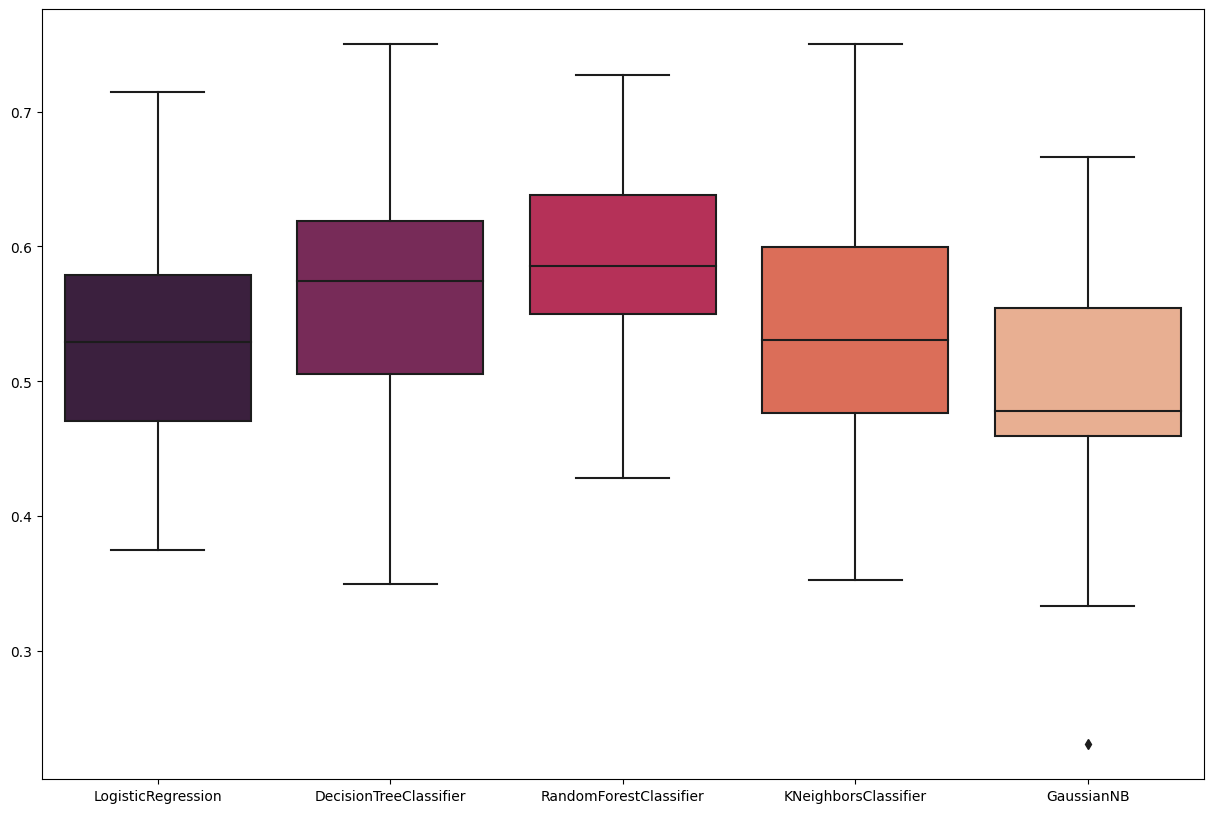

In [10]:
algoritmos = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(), GaussianNB()]

# gerando graficos de comparacao, usando do treino e do teste
graficoComparacao(algoritmos, xTrain, yTrain)

## Melhor Algoritmo
A partir das análises feitas foi possível notar que o melhor algoritmo determinado foi ... por possuir um dos maiores valores de acurácia e precisão, além de possuir uma baixa variação em relação ao uso do cross_validation, como foi apresentado nos gráficos. É importante ressaltar que a decisão final sobre a escolha do algoritmo foi baseada principalmente na variação gráfica dos algoritmos devido ao fator de que com exceção dos algoritmos SVM, AdaBoostClassifier, KNeighborsClassifier os demais possuiram valores muito próximos, tanto de acurácia, quanto de precisão.

Agora deve ser determinado o melhor ajuste de parâmetros para o algoritmo escolhido, em que para isso será utilizado do GridSearch, em que dado alguns parâmetros, e sua variações, o algoritmo retorna o melhor resultado de acordo com uma métrica escolhida.

In [11]:
# imports necessário
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

# parâmetros que serão aleatoriezados
parameters = {'criterion': ['entropy', 'gini'], 'max_depth': [None, 50, 100], 'min_samples_split': [2, 4, 6],
              'max_features': ['auto', 'sqrt', 'log2']}

# classificador usado
dt = DecisionTreeClassifier(random_state=42)

# geração do gridsearch
clf = GridSearchCV(estimator=dt, param_grid=parameters, scoring='precision', cv=10)
clf.fit(xTrain, yTrain)
#clf.cv_results_

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 50, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6]},
             scoring='precision')

In [12]:
# melhores parâmetros
clf.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 6}

In [13]:
# melhor score
clf.best_score_

0.5541204174091974

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, max_features='auto', min_samples_split=2, random_state=42)
dt.fit(xTrain, yTrain)
pred = dt.predict(xTest)

acuracia = accuracy_score(yTest, pred)
precision = precision_score(yTest, pred)
print(f'Acuracia: {acuracia} Precisão: {precision}')

Acuracia: 0.5539568345323741 Precisão: 0.5238095238095238


<Axes: >

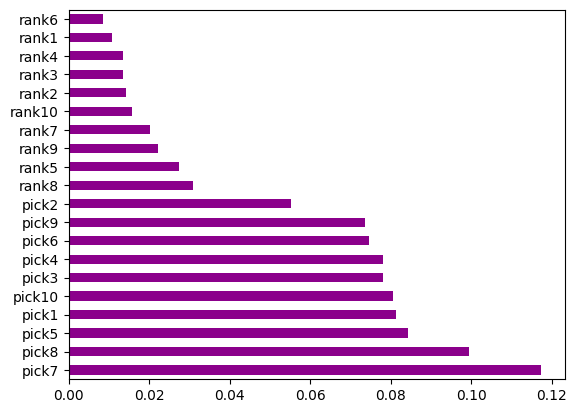

In [15]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(dt.feature_importances_, index=xTrain.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot(kind='barh', color='darkmagenta')

In [16]:
# imports necessário
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

# parâmetros que serão aleatoriezados
parameters = {'n_estimators': [50, 100, 200], 'criterion': ['entropy', 'gini'],
              'max_depth': [None, 50, 100], 'min_samples_split': [2, 4, 6],
              'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True, False]}

# classificador usado
rf = RandomForestClassifier(random_state=42)

# geração do gridsearch
clf = GridSearchCV(estimator=rf, param_grid=parameters, scoring='precision', cv=10)
clf.fit(xTrain, yTrain)
#clf.cv_results_

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 50, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             scoring='precision')

In [17]:
# melhores parâmetros
clf.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 4,
 'n_estimators': 100}

In [18]:
# melhor score
clf.best_score_

0.6116233047176445

In [22]:
rf = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=None, max_features='auto', min_samples_split=4, n_estimators=100, random_state=42)
rf.fit(xTrain, yTrain)
pred = rf.predict(xTest)

acuracia = accuracy_score(yTest, pred)
precision = precision_score(yTest, pred)
print(f'Acuracia: {acuracia} Precisão: {precision}')

Acuracia: 0.5323741007194245 Precisão: 0.5


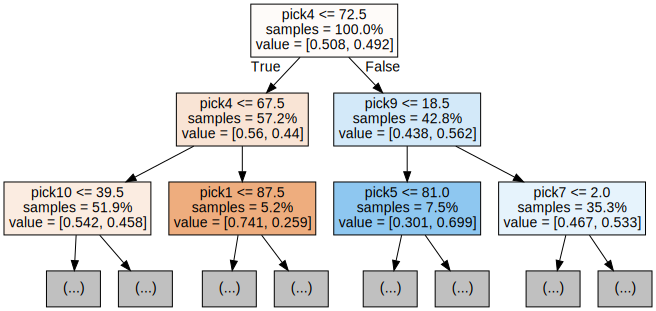

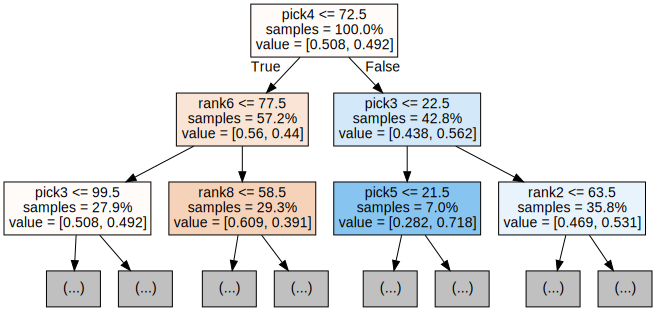

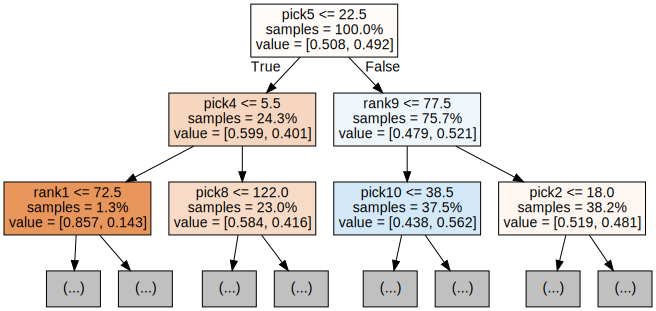

In [23]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# árvore gerada
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=xTrain.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

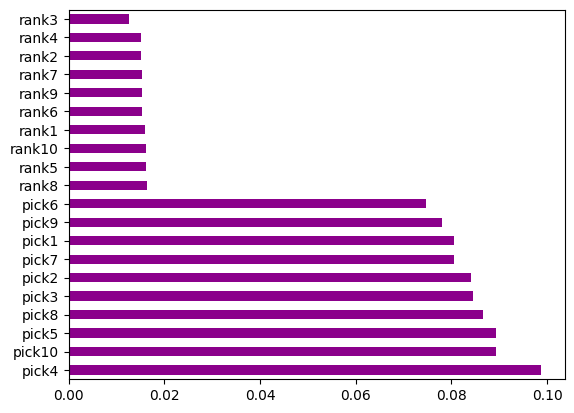

In [26]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=xTrain.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot(kind='barh', color='darkmagenta');